# NREL Lignin structures

In [ ]:
from rdkit import Chem
import cirpy
from polymerist.monomers import specification

In [ ]:
arene_sub_smi = {
    'phenyl_ortho' : '[1*]c1c([1*])cccc1',
    'phenyl_meta'  : '[1*]c1cc([1*])ccc1',
    'phenyl_para'  : '[1*]c1ccc([1*])cc1',
}
sidechain_smi = {
    'methoxy_group'     : '[2*]OC',
    'butyl_ester'       : '[2*]C(=O)OCCCC',
    'hexan-3-yl_ester' : '[2*]C(=O)OCC(CC)CCCC',
}
all_smi = {**arene_sub_smi, **sidechain_smi}

all_mols = {}
for fragname, smi in all_smi.items():
    mol = Chem.MolFromSmiles(smi, sanitize=False)
    Chem.SanitizeMol(mol, sanitizeOps=specification.SANITIZE_AS_KEKULE)
    print(fragname)
    display(mol)
    all_mols[fragname] = mol

In [ ]:
from polymerist.rdutils.labeling import molwise
from polymerist.rdutils.bonding.substitution import saturate_ports

from polymerist.rdutils.bonding import portlib
portlib.Port.bondable_flavors.insert((1,2))


frags_to_link = (
    ('phenyl_ortho', 'butyl_ester'),
    ('phenyl_para',  'butyl_ester'),
    ('phenyl_ortho', 'hexan-3-yl_ester'),
    ('phenyl_para',  'hexan-3-yl_ester'),
)

plasticizer_smi     : dict[str, str] = {}
plasticizer_smi_exp : dict[str, str] = {}
for core_name, cap_name in frags_to_link:
    coremol = all_mols[core_name]
    capmol  = all_mols[cap_name]
    
    spliced_mol = saturate_ports(coremol, cap=capmol, flavor_to_saturate=1)
    Chem.SanitizeMol(spliced_mol, sanitizeOps=specification.SANITIZE_AS_KEKULE)
    molwise.clear_atom_map_nums(spliced_mol, in_place=True)

    smi = Chem.MolToSmiles(spliced_mol)
    exp_smi = specification.expanded_SMILES(smi, assign_map_nums=False)
    iupac_name = cirpy.resolve(smi, 'iupac_name')
    plasticizer_smi[iupac_name] = smi
    plasticizer_smi_exp[iupac_name] = exp_smi

    print(iupac_name)
    display(spliced_mol)

In [ ]:
newmol = saturate_ports(all_mols['phenyl_ortho'], cap=Chem.MolFromSmiles('[2*]-[H]'), flavor_to_saturate=1)
molwise.clear_atom_map_nums(newmol, in_place=True)
Chem.SanitizeMol(newmol, sanitizeOps=specification.SANITIZE_AS_KEKULE)
smi = Chem.MolToSmiles(newmol)

print(smi)
display(newmol)

In [ ]:
heavy = Chem.RemoveHs(newmol, updateExplicitCount=True, sanitize=False)
Chem.SanitizeMol(heavy, sanitizeOps=specification.SANITIZE_AS_KEKULE)
heavy

# Developing monomer graphs

In [3]:
import networkx as nx
from rdkit import Chem

import mbuild
from mbuild.compound import Compound
from mbuild.conversion import load, load_smiles, from_rdkit, to_smiles, to_pybel
from mbuild.lib.recipes.polymer import Polymer

comp = mbuild.Compound()

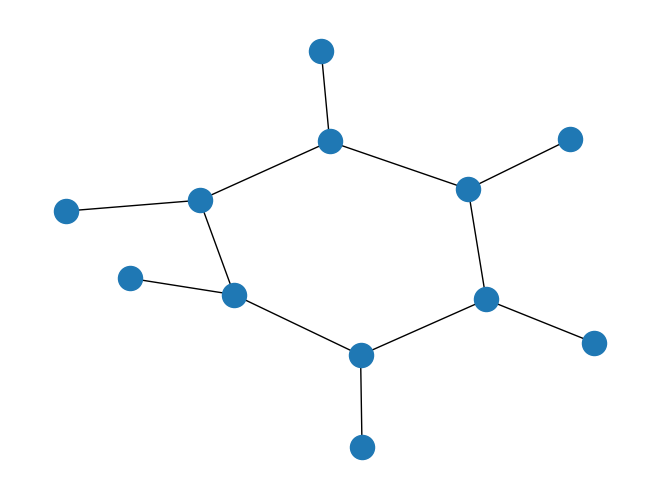

In [9]:
from polymerist.rdutils.rdgraphs import rdmol_to_networkx
from polymerist.monomers import specification

smi = 'c1ccccc1'
exp_smi = specification.expanded_SMILES(smi, assign_map_nums=False)
rdmol = Chem.MolFromSmiles(exp_smi, sanitize=False)
Chem.SanitizeMol(rdmol, sanitizeOps=specification.SANITIZE_AS_KEKULE)

G = rdmol_to_networkx(rdmol)
nx.draw(G)

## Representing monomer fragment linkages as a graph

In [28]:
from typing import Optional
from dataclasses import dataclass, field


def get_num_linkers(rdmol : Chem.Mol) -> int:
    '''Count how many wild-type inter-molecule atoms are in a Mol'''
    return sum(
        (atom.GetAtomicNum() == 0)
            for atom in rdmol.GetAtoms()
    )

@dataclass
class MonomerFragmentInfo:
    '''Naming and in-line chemical encodings for a monomer unit within a polymer chain'''
    name   : str
    smiles : str
    alias  : Optional[str] = field(default=None)
    parent_smiles : Optional[str] = field(default=None) # smiles of the unpolymerized, feedstock monomer this fragment is derived from
    smarts        : Optional[str] = field(default=None)

    n_atoms       : int = field(init=False)
    functionality : int = field(init=False)
    contribution  : int = field(init=False)

    def __post_init__(self) -> None:
        tempmol = self.rdmol
        self.n_atoms = tempmol.GetNumAtoms()
        self.functionality = get_num_linkers(tempmol)
        self.contribution  = self.n_atoms - self.functionality

    @property
    def rdmol(self) -> Chem.Mol:
        return Chem.MolFromSmiles(self.smiles, sanitize=False)

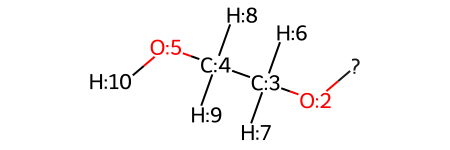

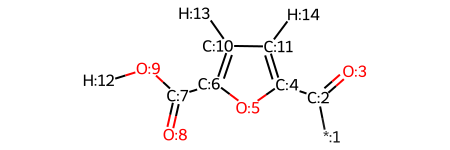

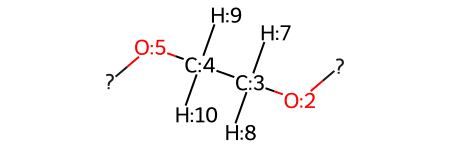

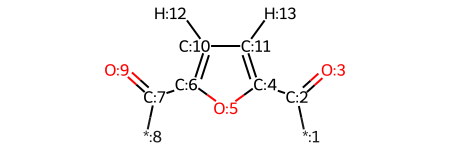

In [29]:
from polymerist.monomers import MonomerGroup

monogrp = MonomerGroup.from_file('poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic acid).json')
moldict, monosmiles = {}, {}
for mononame, rdmol in monogrp.iter_rdmols():
    display(rdmol)
    moldict[   mononame] = rdmol
    monosmiles[mononame] = Chem.MolToSmiles(rdmol)

In [30]:
from string import ascii_uppercase

parent_monomers = {
    'ethane-1,2-diol' : 'OCCO',
    'furan-2,5-dicarboxylic acid' : 'O=C(O)c1ccc(C(=O)O)o1',
}
monomer_aliases = {
    mononame : lett
        for mononame, lett in zip(parent_monomers.keys(), ascii_uppercase)
}

In [79]:
mono_infos = {}
for mononame, smiles in monosmiles.items():
    parent_mononame = mononame.split('_')[0]
    parent_smiles = parent_monomers[parent_mononame]
    parent_alias  = monomer_aliases[parent_mononame]

    mono_info = MonomerFragmentInfo(
        name=mononame,
        smiles=smiles,
        parent_smiles=parent_smiles,
        smarts=specification.compliant_mol_SMARTS(smiles)
    )
    mono_info.alias = parent_alias.lower() if (mono_info.functionality == 1) else parent_alias.upper()
    mono_infos[mono_info.alias] = mono_info

Cleaned 10 SMARTS atom query aberrations introduced by RDKit
Cleaned 14 SMARTS atom query aberrations introduced by RDKit
Cleaned 10 SMARTS atom query aberrations introduced by RDKit
Cleaned 13 SMARTS atom query aberrations introduced by RDKit


In [80]:
mono_infos

{'a': MonomerFragmentInfo(name='ethane-1,2-diol_TERM', smiles='[2*:1][O:2][C:3]([C:4]([O:5][H:10])([H:8])[H:9])([H:6])[H:7]', alias='a', parent_smiles='OCCO', smarts='[2*:1]-[#8D2+0:2]-[#6D4+0:3](-[#6D4+0:4](-[#8D2+0:5]-[#1D1+0:10])(-[#1D1+0:8])-[#1D1+0:9])(-[#1D1+0:6])-[#1D1+0:7]', n_atoms=10, functionality=1, contribution=9),
 'b': MonomerFragmentInfo(name='furan-2,5-dicarboxylic acid_TERM', smiles='[*:1][C:2](=[O:3])[C:4]1=[C:11]([H:14])[C:10]([H:13])=[C:6]([C:7](=[O:8])[O:9][H:12])[O:5]1', alias='b', parent_smiles='O=C(O)c1ccc(C(=O)O)o1', smarts='[*:1]-[#6D3+0:2](=[#8D1+0:3])-[#6D3+0:4]1=[#6D3+0:11](-[#1D1+0:14])-[#6D3+0:10](-[#1D1+0:13])=[#6D3+0:6](-[#6D3+0:7](=[#8D1+0:8])-[#8D2+0:9]-[#1D1+0:12])-[#8D2+0:5]-1', n_atoms=14, functionality=1, contribution=13),
 'A': MonomerFragmentInfo(name='ethane-1,2-diol_MID', smiles='[2*:1][O:2][C:3]([C:4]([O:5][2*:6])([H:9])[H:10])([H:7])[H:8]', alias='A', parent_smiles='OCCO', smarts='[2*:1]-[#8D2+0:2]-[#6D4+0:3](-[#6D4+0:4](-[#8D2+0:5]-[2*:6])

In [164]:
from typing import Generator
from functools import partial


ASCII_PRINTABLE = ''.join(chr(i) for i in range(33, 127)) # ASCII printable characters, minus SPACE (" ", 32) and DELETE (127)

def smallest_repeating_substring(string : str) -> str:
    '''Return the shortest substring such that the passed string can be written as some number of repeats (including 1) of the substring
    Will return the original string if no simpler decomposition exists'''
    i = (2*string).find(string, 1, -1) # check if string matches itself in a cycle in non-trivial way (i.e more than just the two repeats)
    return string if (i == -1) else string[:i]

def parse_with_delimiters(string : str, start_char : str, end_char : str) -> Generator[str, None, None]:
    '''Generates substring contained by starting and ending delimiting characters (and depth of substring) via pushdown automaton mechanism'''
    stack : list[int] = []
    for i, char in enumerate(string):
        if char == start_char:
            stack.append(i)
        if (char == end_char) and stack:
            start_idx = stack.pop()
            yield string[start_idx+1:i], len(stack)

parse_parenthesis     = partial(parse_with_delimiters, start_char='(', end_char=')')
parse_square_brackets = partial(parse_with_delimiters, start_char='[', end_char=']')
parse_curly_brackets  = partial(parse_with_delimiters, start_char='{', end_char='}')

In [189]:
test = '[a][A]([A])[B][A]([A][B]([A][A])[B][C])[A][C][b]'
test2 = test.replace('A', 'A2').replace('B', 'B2').replace('a', 'A1').replace('b', 'B1').replace('C', 'OTHER')

In [190]:
test2

'[A1][A2]([A2])[B2][A2]([A2][B2]([A2][A2])[B2][OTHER])[A2][OTHER][B1]'

In [191]:
from polymerist.genutils.iteration import sliding_window
from itertools import chain

In [262]:
def parse_monograph_string(monostring : str, node_start_idx : int=0) -> nx.Graph:
    '''Parse a SMILES-like monomer graph string and read it into a networkX Graph'''
    G = nx.Graph()
    branch_stack : list[int] = []
    mononame = ''
    prev_idx, curr_idx = None, node_start_idx - 1 # initial with no previous node and the current node being before the starting index
    
    for char in monostring.replace('-', ''):
        if char == '[':                         # 1) if reached a new monomer block...
            mononame = ''                       # clear the current monomer name
            curr_idx += 1                       # and increment the index
        elif char == ']':                       # 2) if reached the end of a monomer block...
            G.add_node(curr_idx, monomer_name=mononame) # add a new node with the current index and name
            if prev_idx is not None: 
                G.add_edge(curr_idx, prev_idx)  # if at least one node exists, link the new node to the prior node
            prev_idx = curr_idx                 # advance the previous node index, or set it if this is the first node 
        elif char == '(':
            branch_stack.append(curr_idx)       # save the current index to the stack before proceeding with traversal
        elif char == ')':                       # 4) if exiting a branch...
            prev_idx = branch_stack.pop()       # retrieve the last saved position after exiting a branch
        else:                                   # 5) otherwise... 
            mononame += char                    # must be inside a monomer block; in that case, just extend the current name
        
    return G


In [306]:
test3 = 'CCC(AA)CCC(BB)CCC(DD)CC'
for char in 'ABCD':
    test3 = test3.replace(char, f'[{char}]')
print(test3)

[C][C][C]([A][A])[C][C][C]([B][B])[C][C][C]([D][D])[C][C]


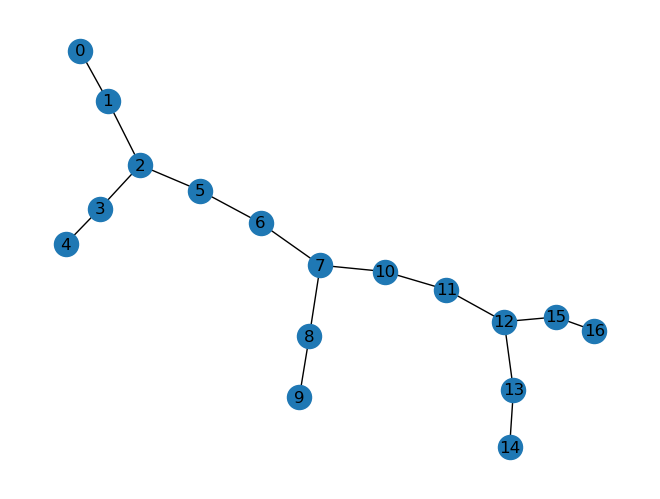

In [307]:
G = parse_monograph_string(test3)

nx.draw(G, with_labels=True)
# nx.draw(G, with_labels=True, labels=nx.get_node_attributes(G, 'monomer_name'))

In [324]:
def parse_monomer_graph_to_string(monograph : nx.Graph, start_node : int=0) -> str:
    '''Convert a monomer graph into a SMILES-like monomer string'''
    branch_dict = {
        node_idx : '('*(len(successors) - 1)
            for node_idx, successors in nx.dfs_successors(monograph, source=start_node).items()
    }

    return ''.join(
        f'[{G.nodes[node_id]["monomer_name"]}]{branch_dict.get(node_id, ")")}'
            for node_id in nx.dfs_preorder_nodes(monograph, source=start_node)
    )[:-1]

In [359]:
src = 10
order = nx.dfs_successors(G, source=src)
order, list(nx.dfs_preorder_nodes(G, source=src))

({10: [7, 11],
  7: [6, 8],
  6: [5],
  5: [2],
  2: [1, 3],
  1: [0],
  3: [4],
  8: [9],
  11: [12],
  12: [13, 15],
  13: [14],
  15: [16]},
 [10, 7, 6, 5, 2, 1, 0, 3, 4, 8, 9, 11, 12, 13, 14, 15, 16])

In [360]:
stack = [src]
out = ''
while stack:
    i = stack.pop()
    out += f'{G.nodes[i]["monomer_name"]}'
    print(i, out)

    if i in order:
        if (len(order[i]) > 1):
            out += '('
        stack.append(order[i].pop(0))
    else:
        out += ')'
    print(stack)

10 C
[7]
7 C(C
[6]
6 C(C(C
[5]
5 C(C(CC
[2]
2 C(C(CCC
[1]
1 C(C(CCC(C
[0]
0 C(C(CCC(CC
[]


In [361]:
out

'C(C(CCC(CC)'

[C]([C]([C][C][C]([C][C])[A][A])[B][B])[C][C]([D][D])[C][C]


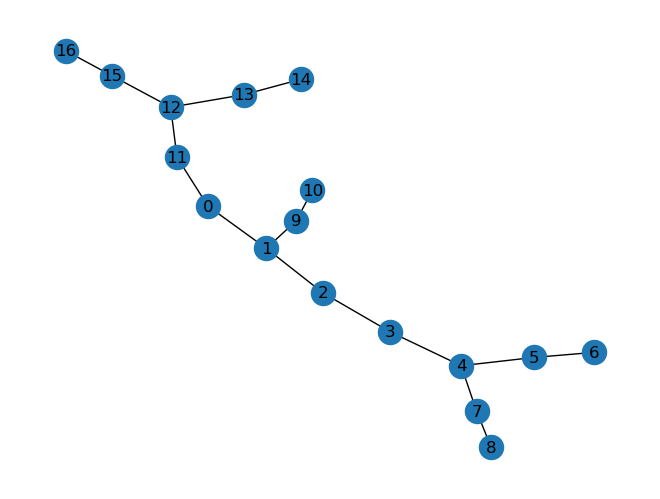

In [345]:
s = parse_monomer_graph_to_string(G, start_node=src)
print(s)
H = parse_monograph_string(s)

nx.draw(H, with_labels=True)
# nx.draw(H, with_labels=True, labels=nx.get_node_attributes(G, 'monomer_name'))

{0: 'A1',
 1: 'A2',
 2: 'A2',
 3: 'B2',
 4: 'A2',
 5: 'A2',
 6: 'B2',
 7: 'A2',
 8: 'A2',
 9: 'B2',
 10: 'OTHER',
 11: 'A2',
 12: 'OTHER',
 13: 'B1'}

In [ ]:
    for i, char in enumerate(monoiter, start=node_start_idx):
        if char == '[':
            char = next(monoiter, '')
            name = ''
            while char != ']':
                name += char
                char = next(monoiter, '')
        print(i, name)
        


In [179]:
l = list(parse_square_brackets(test))

In [181]:
len(l)

14

In [ ]:
    

    num_monos    : int = 0
    unique_monos : set = set()
    for i, (mono_name, depth) in enumerate(parse_square_brackets(monostring)):
        G.add_node(i, monomer_name=mono_name)

        unique_monos.add(mono_name)
        num_monos += 1
        if depth > 0:
            raise ValueError('Cannot nest aliases for monomers (too deeply-nested square brackets)')
        
    return G
    
G = parse_monograph_string(test)

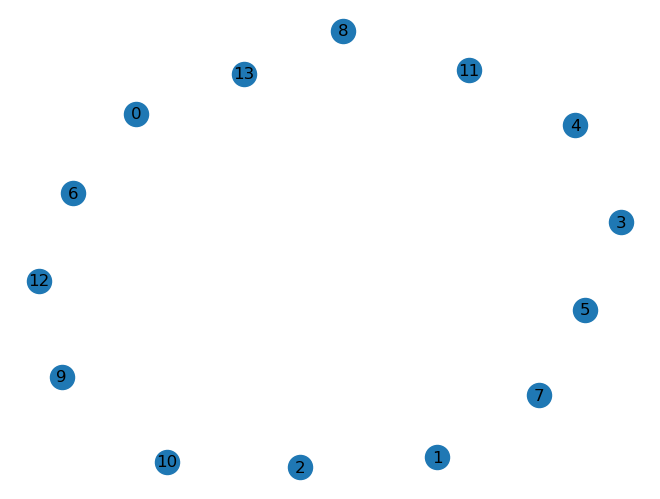

In [160]:
nx.draw(G, with_labels=True)

In [81]:
from itertools import cycle

DOP = 10
seq = ['a'] + ['B', 'A']*int((DOP-2)/2) + ['b']
seq

['a', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'b']

In [123]:
s = ''.join(seq)
s

'aBABABABAb'

In [128]:
help(next)

Help on built-in function next in module builtins:

next(...)
    next(iterator[, default])
    
    Return the next item from the iterator. If default is given and the iterator
    is exhausted, it is returned instead of raising StopIteration.



'!"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~'

In [125]:
smallest_repeating_substring(s[1:-1])

'BA'

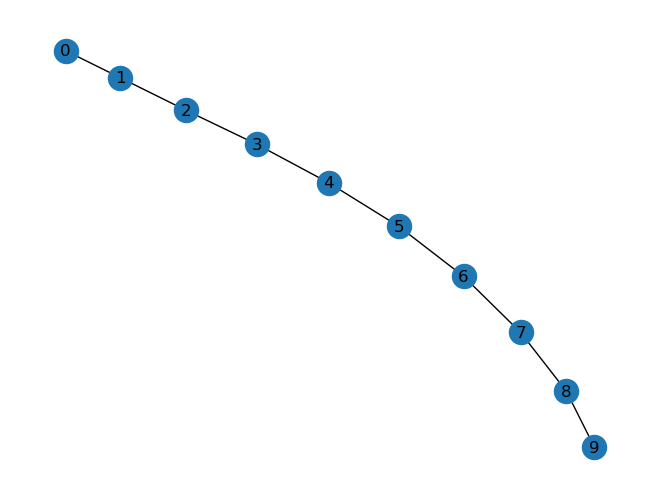

In [70]:
n = 10
t = 5

G = nx.path_graph(len(seq))
attrs = {
    i : mono_infos[alias].__dict__
        for i, alias in enumerate(seq)
}
nx.set_node_attributes(G, attrs)

nx.draw(G, with_labels=True)

In [71]:
G.nodes[0]

{'name': 'ethane-1,2-diol_TERM',
 'smiles': '[2*:1][O:2][C:3]([C:4]([O:5][H:10])([H:8])[H:9])([H:6])[H:7]',
 'alias': 'A1',
 'parent_smiles': 'OCCO',
 'smarts': '[2*:1]-[#8D2+0:2]-[#6D4+0:3](-[#6D4+0:4](-[#8D2+0:5]-[#1D1+0:10])(-[#1D1+0:8])-[#1D1+0:9])(-[#1D1+0:6])-[#1D1+0:7]',
 'n_atoms': 10,
 'functionality': 1,
 'contribution': 9}

In [73]:
G.degree

DegreeView({0: 1, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 1})

In [75]:
nx.get_node_attributes(G, 'functionality')

{0: 1, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2}

In [61]:
list(nx.dfs_preorder_nodes(G))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 13, 12, 11, 10]

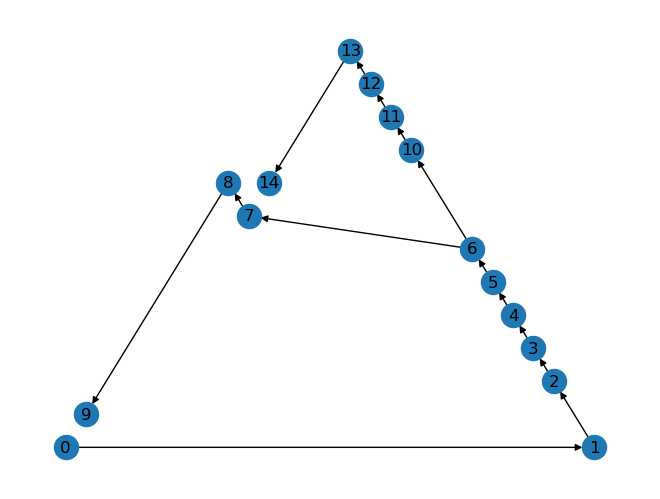

In [57]:
tree = nx.dfs_tree(G)
nx.draw_planar(tree, with_labels=True)

In [ ]:

T = nx.path_graph(5)
G = nx.compose(G, T)

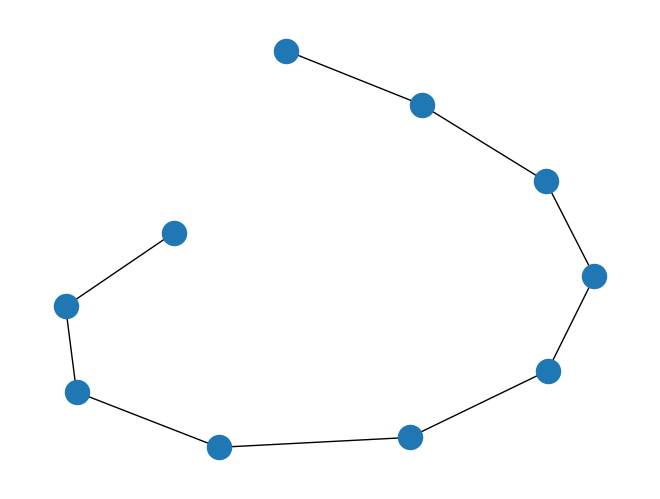

In [40]:
nx.draw(G)

In [ ]:
from string import ascii_uppercase

for let in ascii_uppercase:
    print(let)

In [ ]:
from polymerist.genutils.iteration import iter_len




for name, mol in mol_dict.items():
    print(get_num_linkers(mol), mol.GetNumAtoms())

# Developing more robust IBIS which can handle rings

In [ ]:
import json
import pandas as pd
from pathlib import Path

from polymerist.rdutils.reactions import reactions

import networkx as nx
from rdkit import Chem

from polymerist.rdutils.rdtypes import RDMol
from polymerist.rdutils.rdgraphs import rdmol_to_networkx
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights
from polymerist.rdutils.reactions import reactors, reactions, fragment

## Load rxn reference data

In [ ]:
# Static Paths
RAW_DATA_DIR  = Path('monomer_data_raw')
FMT_DATA_DIR  = Path('monomer_data_formatted')
PROC_DATA_DIR = Path('monomer_data_processed')
RXN_FILES_DIR = Path('poly_rxns')

with (RXN_FILES_DIR / 'rxn_groups.json').open('r') as file: # load table of functional group for each reaction
    rxn_groups = json.load(file)

rxns = {
    rxnname : reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_DIR / f'{rxnname}.rxn')
        for rxnname in rxn_groups.keys()
}

In [ ]:
df = pd.read_csv(PROC_DATA_DIR / 'monomer_data_MASTER.csv', index_col=[0,1])
frames_by_mech = {
    mechanism : df.xs(mechanism)
        for mechanism in df.index.unique(level=0)
}

## Individual reaction

In [ ]:
from polymerist.monomers import specification
from polymerist.rdutils.rdkdraw import set_rdkdraw_size
set_rdkdraw_size(300, 3/2)


# mech = 'polyurethane_isocyanate'
mech = 'polyamide'
mech = 'polyurethane_nonisocyanate'
mech = 'polyester'
mech = 'polycarbonate_phosgene'
mech = 'polyimide'
# mech = 'vinyl'

frame = frames_by_mech[mech]
row = frame.iloc[3]
rxn = rxns[mech]
reactor = reactors.PolymerizationReactor(rxn)
display(rxn)

reactants = []
for index in range(2):
    smi = row[f'smiles_monomer_{index}']
    exp_smi = specification.expanded_SMILES(smi, assign_map_nums=False)
    mol = Chem.MolFromSmiles(exp_smi, sanitize=False)
    display(mol)

    reactants.append(mol)

In [ ]:
set_rdkdraw_size(500)

products = reactor.react(reactants)
for product in products:
    Chem.SanitizeMol(product, sanitizeOps=specification.SANITIZE_AS_KEKULE)
    display(product)

In [ ]:
G = rdmol_to_networkx(product)

elem_colors = {
    'C' : 'gray',
    'O' : 'red',
    'N' : 'blue',
    'H' : 'green',
    'Cl' : 'purple'
}

nx.draw(
    G,
    pos=nx.spring_layout(G),
    node_color=[elem_colors[symbol] for symbol in nx.get_node_attributes(G, 'symbol').values()],
    with_labels=True
)

In [ ]:
S = G.subgraph(nx.get_node_attributes(G, 'molRxnRole').keys())
# S = G.subgraph(i for i, symbol in nx.get_node_attributes(G, 'atomic_num').items() if symbol > 1)

pos = nx.spring_layout(S)
nx.draw(
    S,
    pos=pos,
    node_color=[elem_colors[symbol] for symbol in nx.get_node_attributes(S, 'symbol').values()],
    with_labels=True
)

edge_labels = { # label by RDKit bond number
    (u, v) : data['idx']
        for u, v, data in S.edges(data=True)
}
# edge_labels = { # label by distint chains in chain decomposition
#     (u, v) : i
#         for i, chain in enumerate(nx.chain_decomposition(S)) 
#             for u, v in chain
# }
list(nx.chain_decomposition(S))
_ = nx.draw_networkx_edge_labels(
    S,
    pos=pos,
    edge_labels=edge_labels
)

In [ ]:
nx.get_node_attributes(S, 'was_dummy').keys(), nx.get_node_attributes(S, 'molRxnRole').keys()

In [ ]:
from itertools import combinations
from polymerist.genutils.iteration import sliding_window

node_pairs_to_edges = lambda pairs : [S.edges[*edge]['idx'] for edge in pairs]


bridges = set(node_pairs_to_edges(nx.bridges(S)))
former_bh_ids = nx.get_node_attributes(S, 'was_dummy').keys() # not checking for heavies here
new_bond_ids = {i for i in rxn.product_info_maps[0].new_bond_ids_to_map_nums}

for bh_id_pair in combinations(former_bh_ids, 2):
    path_edges = node_pairs_to_edges(nx.utils.pairwise(nx.shortest_path(S, *bh_id_pair)))
    print(bh_id_pair, path_edges, set.intersection(set(path_edges), bridges))

In [ ]:
from openff.interchange import Interchange

In [ ]:
new_bond_ids

In [ ]:
former_bh_ids = nx.get_node_attributes(S, 'was_dummy').keys() # not checking for heavies here

In [ ]:

bridge_edge_ids = [G.edges[*edge]['idx'] for edge in bridges]
new_edge_ids = [i for i in rxn.product_info_maps[0].new_bond_ids_to_map_nums]
former_bh_ids = nx.get_node_attributes(S, 'was_dummy').keys() # not checking for heavies here

bh_paths = {}
bh_bridges = {}
for bh_id_pair in combinations(former_bh_ids, 2):
    paths = [
        [S.edges[*path_edges]['idx'] for path_edges in path]
            for path in nx.all_simple_edge_paths(S, *bh_id_pair) 
    ]
    bh_paths[bh_id_pair] = paths

    


In [ ]:
list(sliding_window(nx.shortest_path(S, 1, 7), n=2))

In [ ]:
bridges

In [ ]:
Chem.GetShortestPath(product, 0,12)

In [ ]:
nx.shortest_path(G, 0, 12)

In [ ]:
bridges

In [ ]:

class CutBridgesNearReactingAtoms(reactors.IBIS):
    '''IBIS which looks for bridges occurring within the activate portion of a reaction product to minimize the number of cuts made'''
    def locate_intermonomer_bonds(self, product: RDMol, product_info: reactors.RxnProductInfo) -> reactors.Generator[int, None, None]:
        return super().locate_intermonomer_bonds(product, product_info)

In [ ]:
def test():
    former_bh_ids = [atom_id for match in prod.GetSubstructMatches(fragment.HEAVY_FORMER_LINKER_QUERY) for atom_id in match]
    bridge_bond_ids = {prod.GetBondBetweenAtoms(*pair).GetIdx() for pair in bridges}
    print(bridge_bond_ids)
    new_bond_ids = set(rxn.product_info_maps[0].new_bond_ids_to_map_nums)

    new_bridge_bond_ids = set.intersection(bridge_bond_ids, new_bond_ids)
    if new_bridge_bond_ids:
        yield from new_bridge_bond_ids
    else:
        for bh_id_pair in combinations(former_bh_ids, 2):
            for path in nx.all_simple_edge_paths(S, *bh_id_pair):
                path_edges = set(S.edges[*pair]['idx'] for pair in path)
                if set.intersection(path_edges, new_bond_ids):
                    yield from set.intersection(path_edges, bridge_bond_ids)

In [ ]:
BUFFER = '='*10
for i, (dimers, frags) in enumerate(reactor.propagate(reactants)):
    print(f'{BUFFER}STEP {i}{BUFFER}')
    for j, dim in enumerate(dimers):
        print(f'Dimer {i}-{j}')
        display(dim)
    bins = []
    for j, frag in enumerate(frags):
        print(f'Fragment {i}-{j}')
        display(frag)